### **Imports**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

from keras import models
from keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import LSTM, Bidirectional, GRU, Dropout

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## **1. Reading Toxic Comments Dataset**

In [3]:
raw_train = pd.read_csv('../input/jigsaw-toxic-comment-classification/train.csv', index_col='id')
raw_test = pd.read_csv('../input/jigsaw-toxic-comment-classification/test.csv', index_col='id')

In [4]:
raw_train.rename(columns={'comment_text': 'comment'}, inplace=True)
raw_test.rename(columns={'comment_text': 'comment'}, inplace=True)

In [5]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159571 entries, 0000997932d777bf to fff46fc426af1f9a
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment        159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 9.7+ MB


In [6]:
raw_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153164 entries, 00001cee341fdb12 to ffffce3fb183ee80
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   comment  153164 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB


## **2. EDA**

#### **2.1 Show a sample of data**
(to find out the required text preprocessing steps)

In [7]:
raw_train.head()

,comment,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [8]:
raw_test.head()

,comment
id,
00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"
0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO."
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """
00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message."
00017695ad8997eb,I don't anonymously edit articles at all.


In [9]:
raw_train.comment.sample(random_state=42)

id
7ca72b5b9c688e9e    Geez, are you forgetful!  We've already discussed why Marx  was  not an anarchist, i.e. he wanted to use a State to mold his 'socialist man.'  Ergo, he is a statist - the opposite of an  anarchist.  I know a guy who says that, when he gets old and his teeth fall out, he'll quit eating meat.  Would you call him a vegetarian?
Name: comment, dtype: object

#### **2.2 Check for duplicates**

In [10]:
raw_train.duplicated().sum()

0

In [11]:
raw_train.duplicated(subset=['comment']).sum()

0

In [12]:
raw_test.duplicated().sum()

0

#### **2.3 Check for URLs**

In [13]:
raw_train.comment.str.findall(r'https?:\/\/\S*').drop_duplicates(keep=False)

id
000c0dfd995809fa                                                                                                                                                                                       [http://www.its.caltech.edu/~atomic/snowcrystals/myths/myths.htm#perfection]
001363e1dbe91225                                                                                                                                                                                               [http://digg.com/music/Wikipedia_has_free_classical_music_downloads]
002c9cccf2f1d05b                                                                                                                                        [http://www.constitution.ie/reports/ConstitutionofIreland.pdf, http://www.constitution.ie/reports/mbunreachtnaheireann.pdf]
0038f191ffc93d75                                                                                                                                                         

#### **2.4 Check for Emails and mentions**

In [14]:
raw_train.comment.str.findall(r'\S*@\S+').drop_duplicates(keep=False)

id
0236f714de182059                      [apriljohnson6868@gmail.com]
03585d8dd27a3653                            [animeking237@aol.com]
055c9cafcdb359f9    [bathory@bathory.org, bathory@maltedmedia.com]
05ee06363d9dda77                                  [jeff@fugly.com]
0675ca47f054c2c0                                           [@Matt]
                                         ...                      
ea17eecb83be13ee                             [manasgarg@gmail.com]
ee831c8c79c9984f                                         [@'''''']
ef12914c33ab46b5                                     [@Powergate:]
f1ac66faba2e5bae                             [@Tznkai:, @Snowman:]
f5379a104a9276a2                                 [last@yourhouse.]
Name: comment, Length: 621, dtype: object

#### **2.5 Check for Hashtags**

In [15]:
raw_train.comment.str.findall(r'#\S+').drop_duplicates(keep=False)

id
0001b41b1c6bb37e                                                                                                                                                [#Transport]
000c0dfd995809fa                                                                                                                                               [#perfection]
001363e1dbe91225    [#Need_help.21Wikipedia_talk:WikiProject_Music/Archive_3#I_could_use_some_helpWikipedia_talk:WikiProject_Music/Archive_2#Raulbot.2C_and_the_music_list)]
003b9f448ee4a29d                                                                                             [#WP:V_-_comparing_Jewish_Virtual_Library_and_Dissident_Voice.]
00585c1da10b448b                                                                                                                                                    [#5-5-5]
                                                                                              ...                                   

#### **2.6 Check for HTML tags**

In [16]:
raw_train.comment.str.findall(r'<.*>').drop_duplicates(keep=False)

id
0e343b7f449df75a                                                                                                                                                                                                   [<  | ∂drini >]
1905ca9ef49186a3                                                                          [< http://theregister.co.uk/2008/02/01/woolworths_bed_outrage >, < http://www.woolworths.co.uk/web/jsp/product/index.jsp?pid=11401556 >]
1ae9fbf8d8bc558c                                                                                                                     [<ɰ> is a more appropriate symbol.  was useful because it was found on typewriters while <ɰ>]
1c60ea64111132c6                                                                                                                                                                                         [<| 09.10.2007 | Monday>]
2917d00d75fa9c1d                                                                         

#### **2.7 Check for dataset imbalance**

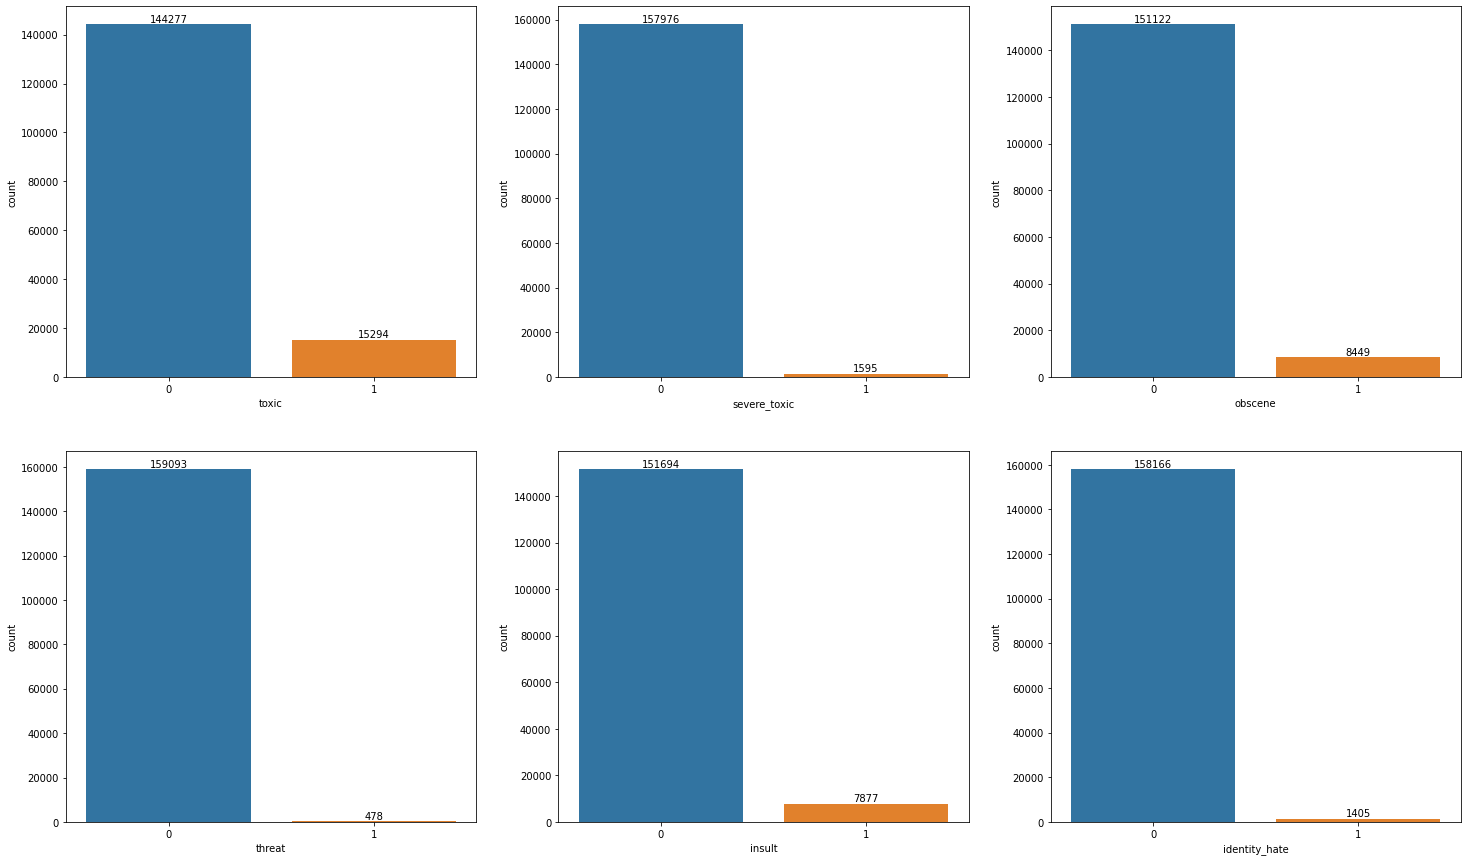

In [17]:
target_cols = raw_train.select_dtypes(include=np.number).columns
fig, ax = plt.subplots(2, 3, figsize=(25, 15))

for col, subplot in zip(target_cols, ax.flatten()):
    sns.countplot(x=raw_train[col], ax=subplot)
    for p in subplot.patches:
        x_ = p.get_bbox().get_points()[:,0]
        y_ = p.get_bbox().get_points()[1,1]
        subplot.annotate(p.get_height(), (x_.mean(), y_), ha='center', va='bottom')
        
plt.show()

#### **2.8 Number of comments in each category**

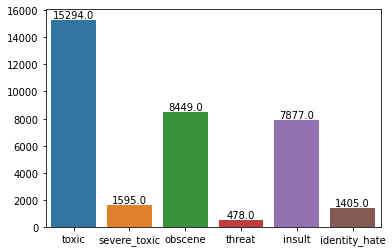

In [18]:
ax = sns.barplot(x=target_cols, y=raw_train[target_cols].sum(axis=0))
for p in ax.patches:
    x_ = p.get_bbox().get_points()[:,0]
    y_ = p.get_bbox().get_points()[1,1]
    ax.annotate(p.get_height(), (x_.mean(), y_), ha='center', va='bottom')

#### **2.9 Comments with multi-labels**

Text(0, 0.5, 'No. of Comments')

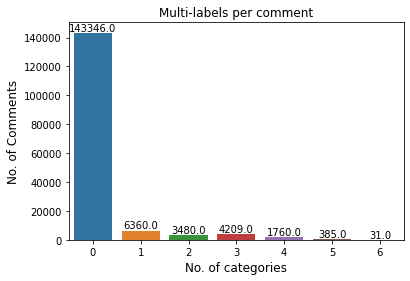

In [19]:
nLabels = raw_train[target_cols].sum(axis=1).value_counts()

ax = sns.barplot(x=nLabels.index, y=nLabels.values)
for p in ax.patches:
    x_ = p.get_bbox().get_points()[:,0]
    y_ = p.get_bbox().get_points()[1,1]
    ax.annotate(p.get_height(), (x_.mean(), y_), ha='center', va='bottom')
    
plt.title("Multi-labels per comment")
plt.xlabel('No. of categories', fontsize=12)
plt.ylabel('No. of Comments', fontsize=12)

## **3. Text Preprocessing**

#### **3.1 Remove URLs**

In [20]:
def remove_urls(text):
    return re.sub(r'https?:\/\/\S*', '', text, flags=re.MULTILINE)

#### **3.2 Remove Emails and Mentions**

In [21]:
def remove_emails_and_mentions(text):
    return re.sub(r'\S*@\S+', '', text, flags=re.MULTILINE)

#### **3.3 Remove Hashtags**

In [22]:
def remove_hashtags(text):
    return re.sub(r'#\S+', '', text, flags=re.MULTILINE)

#### **3.4 Remove HTML tags**

In [23]:
def remove_html_tags(text):
    return re.sub(r'<+.*>+', '', text, flags=re.MULTILINE)

#### **3.5 Remove whitespaces**

In [24]:
def remove_whitespaces(text):
    text = re.sub(r'\s+', ' ', text, flags=re.MULTILINE)
    return text.strip()

#### **3.6 Convert text to lower case**

In [25]:
def to_lowercase(text):
    return text.lower()

#### **3.7 Remove all special characters**

In [26]:
def remove_special_chars(text):
    return re.findall(r'[a-z]{3,}', text)

#### **3.8 Remove stopwords**

In [27]:
def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    return [word for word in words if word not in stop_words]

#### **3.9 Lemmatization**

In [28]:
def lemmatization(words):
    lemmatizer = WordNetLemmatizer()
    return ' '.join(lemmatizer.lemmatize(word) for word in words)

#### **Putting all the pipeline together**

In [29]:
def text_preprocessing(text):
    text = remove_urls(text)
    text = remove_emails_and_mentions(text)
    text = remove_hashtags(text)
    text = remove_html_tags(text)
    text = remove_whitespaces(text)
    text = to_lowercase(text)
    words = remove_special_chars(text)
    words = remove_stopwords(words)
    text = lemmatization(words)
    return text

#### **Applying text preprocessing on train and test sets**

In [30]:
train = raw_train.copy()
test = raw_test.copy()

In [31]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [32]:
train.comment = train.comment.apply(text_preprocessing)

In [33]:
test.comment = test.comment.apply(text_preprocessing)

#### **Showing a sample of data before and after cleaning**

In [34]:
raw_train.comment.sample(random_state=42)

id
7ca72b5b9c688e9e    Geez, are you forgetful!  We've already discussed why Marx  was  not an anarchist, i.e. he wanted to use a State to mold his 'socialist man.'  Ergo, he is a statist - the opposite of an  anarchist.  I know a guy who says that, when he gets old and his teeth fall out, he'll quit eating meat.  Would you call him a vegetarian?
Name: comment, dtype: object

In [35]:
train.comment.sample(random_state=42)

id
7ca72b5b9c688e9e    geez forgetful already discussed marx anarchist wanted use state mold socialist man ergo statist opposite anarchist know guy say get old teeth fall quit eating meat would call vegetarian
Name: comment, dtype: object

#### **Splitting data**

In [36]:
x_train_df, x_val_df, y_train_df, y_val_df = train_test_split(train.comment, train[target_cols], test_size=0.2, random_state=42)

In [37]:
x_test_df = test.comment

In [38]:
print('x_train shape: {}'.format(x_train_df.shape))
print('y_train shape: {}'.format(y_train_df.shape))
print('x_valid shape: {}'.format(x_val_df.shape))
print('y_valid shape: {}'.format(y_val_df.shape))
print('x_test shape:  {}'.format(x_test_df.shape))

x_train shape: (127656,)
y_train shape: (127656, 6)
x_valid shape: (31915,)
y_valid shape: (31915, 6)
x_test shape:  (153164,)


## **4. Model**

### **4.1 FFNN Model with BoW (TF-IDF) Text Representation**

#### **4.1.1 BoW**

In [39]:
vocab_size = 1000
vectorizer = TfidfVectorizer(max_features=vocab_size)
vectorizer.fit(pd.concat([train.comment, test.comment], axis=0))

TfidfVectorizer(max_features=1000)

In [40]:
x_train = vectorizer.transform(x_train_df).toarray()
x_val = vectorizer.transform(x_val_df).toarray()
x_test = vectorizer.transform(x_test_df).toarray()

In [41]:
y_train = np.asarray(y_train_df).astype('float32')
y_val = np.asarray(y_val_df).astype('float32')

In [42]:
print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('x_valid shape: {}'.format(x_val.shape))
print('y_valid shape: {}'.format(y_val.shape))
print('x_test shape:  {}'.format(x_test.shape))

x_train shape: (127656, 1000)
y_train shape: (127656, 6)
x_valid shape: (31915, 1000)
y_valid shape: (31915, 6)
x_test shape:  (153164, 1000)


#### **4.1.2 FFNN Model**

In [43]:
nn_model = models.Sequential()
nn_model.add(layers.Dense(16, activation='relu', input_shape=(vocab_size,)))
nn_model.add(layers.Dense(32, activation='relu'))
nn_model.add(layers.Dense(6, activation='sigmoid'))
nn_model.summary()

2022-07-09 21:48:00.067907: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 21:48:00.180343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 21:48:00.181209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                16016     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 16,758
Trainable params: 16,758
Non-trainable params: 0
_________________________________________________________________


2022-07-09 21:48:00.183236: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-09 21:48:00.183600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 21:48:00.184716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 21:48:00.185949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

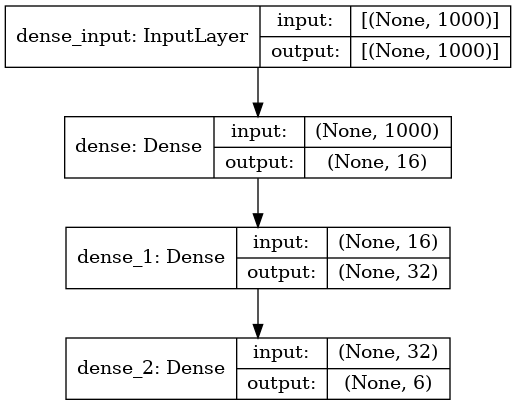

In [44]:
plot_model(nn_model, to_file='nn_model.png', show_shapes=True)

In [45]:
nn_model.compile(optimizer=optimizers.Adam(),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [46]:
history = nn_model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val))

2022-07-09 21:48:05.608179: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
250/250 [==============================] - 3s 6ms/step - loss: 0.2609 - binary_accuracy: 0.9430 - val_loss: 0.0846 - val_binary_accuracy: 0.9748
Epoch 2/10
250/250 [==============================] - 1s 4ms/step - loss: 0.0682 - binary_accuracy: 0.9785 - val_loss: 0.0638 - val_binary_accuracy: 0.9794
Epoch 3/10
250/250 [==============================] - 1s 4ms/step - loss: 0.0611 - binary_accuracy: 0.9800 - val_loss: 0.0615 - val_binary_accuracy: 0.9799
Epoch 4/10
250/250 [==============================] - 1s 4ms/step - loss: 0.0591 - binary_accuracy: 0.9803 - val_loss: 0.0605 - val_binary_accuracy: 0.9802
Epoch 5/10
250/250 [==============================] - 1s 4ms/step - loss: 0.0579 - binary_accuracy: 0.9805 - val_loss: 0.0598 - val_binary_accuracy: 0.9804
Epoch 6/10
250/250 [==============================] - 1s 4ms/step - loss: 0.0570 - binary_accuracy: 0.9807 - val_loss: 0.0592 - val_binary_accuracy: 0.9805
Epoch 7/10
250/250 [==============================] - 1s 4ms/ste

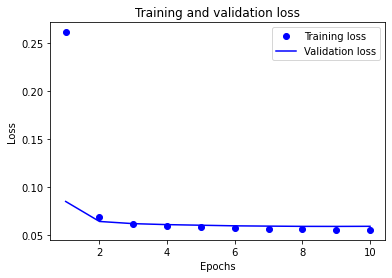

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

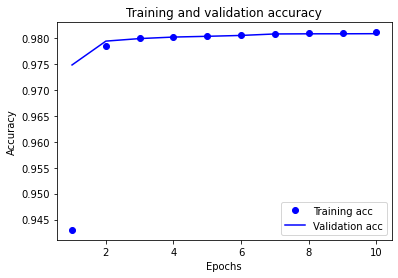

In [48]:
plt.clf()

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [49]:
preds = pd.DataFrame(nn_model.predict(x_test), index=test.index, columns=target_cols)

2022-07-09 21:48:18.396050: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 612656000 exceeds 10% of free system memory.
2022-07-09 21:48:19.072054: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 612656000 exceeds 10% of free system memory.


In [50]:
preds

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.995325,0.303440,0.979082,0.072247,0.887658,0.326814
0000247867823ef7,0.006864,0.000140,0.001527,0.000138,0.002539,0.000112
00013b17ad220c46,0.011609,0.000235,0.003273,0.000207,0.003715,0.000147
00017563c3f7919a,0.002509,0.000094,0.000783,0.000152,0.000805,0.000077
00017695ad8997eb,0.014417,0.000371,0.002819,0.000511,0.004540,0.000459
...,...,...,...,...,...,...
fffcd0960ee309b5,0.540209,0.001439,0.094584,0.000942,0.087054,0.003997
fffd7a9a6eb32c16,0.075934,0.001251,0.016711,0.001460,0.019408,0.002338
fffda9e8d6fafa9e,0.001344,0.000052,0.000468,0.000085,0.000460,0.000037


In [51]:
preds.to_csv('FFNN2_submission.csv')

### **4.2 Sequential Models with Word Embeddings Text Representation**

In [52]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([train.comment, test.comment], axis=0))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

262565

In [53]:
x_train = tokenizer.texts_to_sequences(x_train_df)
x_val = tokenizer.texts_to_sequences(x_val_df)
x_test = tokenizer.texts_to_sequences(x_test_df)

In [54]:
max_length = len(max(x_train, key=len))
max_length

1250

In [55]:
max_length = 200
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_val = pad_sequences(x_val, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

#### **4.2.1 Simple RNN Model**

In [56]:
rnn_model = models.Sequential()
rnn_model.add(layers.Embedding(vocab_size, 8, input_length=max_length))
rnn_model.add(layers.SimpleRNN(8))
rnn_model.add(layers.Dense(16, activation='relu'))
rnn_model.add(layers.Dense(6, activation='sigmoid'))
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 8)            2100520   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 102       
Total params: 2,100,902
Trainable params: 2,100,902
Non-trainable params: 0
_________________________________________________________________


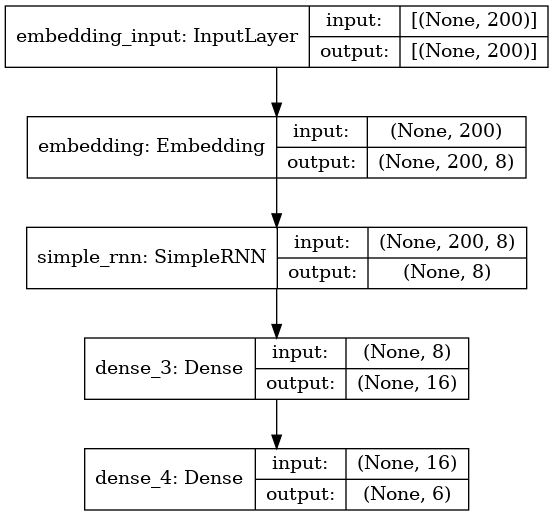

In [57]:
plot_model(rnn_model, to_file='rnn_model.png', show_shapes=True)

In [58]:
rnn_model.compile(optimizer=optimizers.Adam(),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [59]:
history = rnn_model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/10
250/250 [==============================] - 49s 193ms/step - loss: 0.2872 - binary_accuracy: 0.8921 - val_loss: 0.1497 - val_binary_accuracy: 0.9631
Epoch 2/10
250/250 [==============================] - 47s 187ms/step - loss: 0.1429 - binary_accuracy: 0.9634 - val_loss: 0.1421 - val_binary_accuracy: 0.9630
Epoch 3/10
250/250 [==============================] - 47s 190ms/step - loss: 0.1408 - binary_accuracy: 0.9634 - val_loss: 0.1415 - val_binary_accuracy: 0.9632
Epoch 4/10
250/250 [==============================] - 47s 189ms/step - loss: 0.1399 - binary_accuracy: 0.9637 - val_loss: 0.1403 - val_binary_accuracy: 0.9635
Epoch 5/10
250/250 [==============================] - 48s 191ms/step - loss: 0.1379 - binary_accuracy: 0.9643 - val_loss: 0.1380 - val_binary_accuracy: 0.9642
Epoch 6/10
250/250 [==============================] - 47s 187ms/step - loss: 0.1350 - binary_accuracy: 0.9651 - val_loss: 0.1348 - val_binary_accuracy: 0.9651
Epoch 7/10
250/250 [==========================

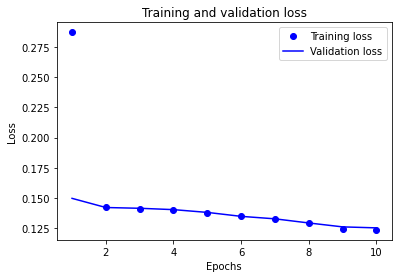

In [60]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

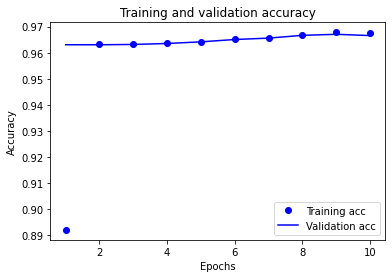

In [61]:
plt.clf()

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### **4.2.2 LSTM Model**

In [62]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM

lstm_model = models.Sequential()
lstm_model.add(Embedding(vocab_size, 128, input_length=max_length, mask_zero=True))
lstm_model.add(LSTM(100, return_sequences=True))
lstm_model.add(LSTM(50))

# lstm_model.add(layers.Dense(16, activation='relu'))
# lstm_model.add(layers.Dense(32, activation='relu'))


lstm_model.add(layers.Dense(6, activation='sigmoid'))
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          33608320  
_________________________________________________________________
lstm (LSTM)                  (None, 200, 100)          91600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 306       
Total params: 33,730,426
Trainable params: 33,730,426
Non-trainable params: 0
_________________________________________________________________


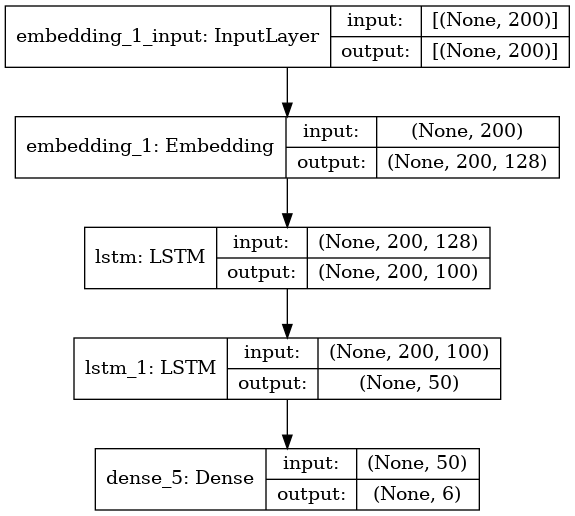

In [63]:
plot_model(lstm_model, to_file='LSTM_model.png', show_shapes=True)

In [64]:
lstm_model.compile(optimizer=optimizers.Adam(),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [65]:
history = lstm_model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/10


2022-07-09 21:57:20.741312: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


250/250 [==============================] - 93s 344ms/step - loss: 0.1575 - binary_accuracy: 0.9635 - val_loss: 0.1098 - val_binary_accuracy: 0.9702
Epoch 2/10
250/250 [==============================] - 86s 345ms/step - loss: 0.0793 - binary_accuracy: 0.9758 - val_loss: 0.0657 - val_binary_accuracy: 0.9765
Epoch 3/10
250/250 [==============================] - 90s 357ms/step - loss: 0.0533 - binary_accuracy: 0.9804 - val_loss: 0.0568 - val_binary_accuracy: 0.9794
Epoch 4/10
250/250 [==============================] - 83s 331ms/step - loss: 0.0455 - binary_accuracy: 0.9831 - val_loss: 0.0551 - val_binary_accuracy: 0.9806
Epoch 5/10
250/250 [==============================] - 88s 355ms/step - loss: 0.0400 - binary_accuracy: 0.9849 - val_loss: 0.0550 - val_binary_accuracy: 0.9803
Epoch 6/10
250/250 [==============================] - 87s 350ms/step - loss: 0.0367 - binary_accuracy: 0.9862 - val_loss: 0.0568 - val_binary_accuracy: 0.9804
Epoch 7/10
250/250 [==============================] - 84s

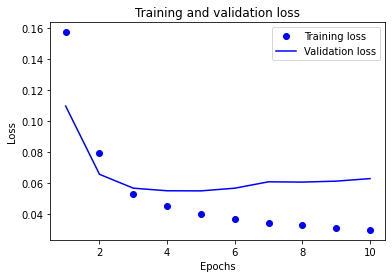

In [66]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

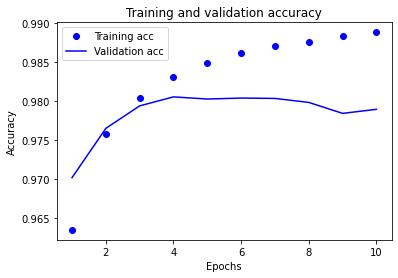

In [67]:
plt.clf()

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### **4.2.3 Bi-LSTM Model**

In [68]:
Bilstm_model = models.Sequential()
Bilstm_model.add(Embedding(vocab_size, 128, input_length=200, mask_zero=True))
Bilstm_model.add(Bidirectional(LSTM(100)))
Bilstm_model.add(Dropout(0.5))
Bilstm_model.add(layers.Dense(6, activation='sigmoid'))
Bilstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          33608320  
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               183200    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 1206      
Total params: 33,792,726
Trainable params: 33,792,726
Non-trainable params: 0
_________________________________________________________________


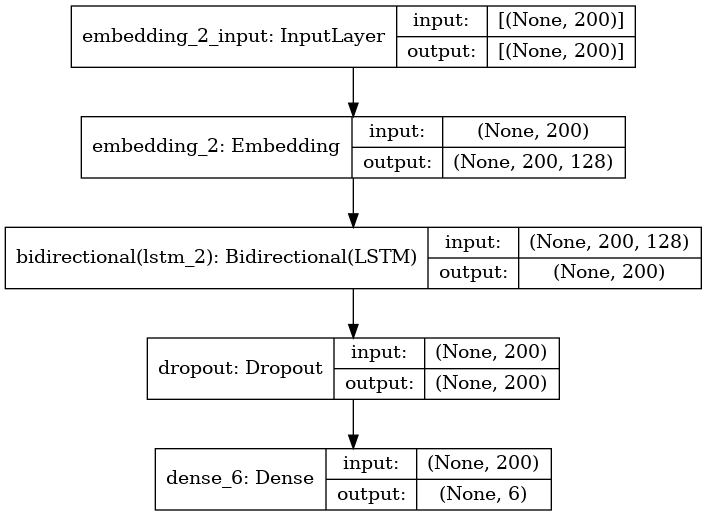

In [69]:
plot_model(Bilstm_model, to_file='BiLSTM_model.png', show_shapes=True)

In [70]:
Bilstm_model.compile(optimizer=optimizers.Adam(),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [71]:
history = Bilstm_model.fit(x_train,
                    y_train,
                    epochs=5,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/5
250/250 [==============================] - 95s 358ms/step - loss: 0.1406 - binary_accuracy: 0.9648 - val_loss: 0.0695 - val_binary_accuracy: 0.9766
Epoch 2/5
250/250 [==============================] - 82s 329ms/step - loss: 0.0564 - binary_accuracy: 0.9804 - val_loss: 0.0546 - val_binary_accuracy: 0.9807
Epoch 3/5
250/250 [==============================] - 86s 346ms/step - loss: 0.0442 - binary_accuracy: 0.9836 - val_loss: 0.0543 - val_binary_accuracy: 0.9807
Epoch 4/5
250/250 [==============================] - 86s 342ms/step - loss: 0.0388 - binary_accuracy: 0.9853 - val_loss: 0.0554 - val_binary_accuracy: 0.9802
Epoch 5/5
250/250 [==============================] - 86s 339ms/step - loss: 0.0358 - binary_accuracy: 0.9864 - val_loss: 0.0567 - val_binary_accuracy: 0.9801


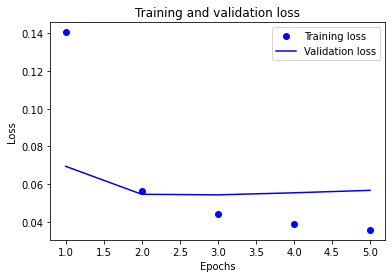

In [72]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

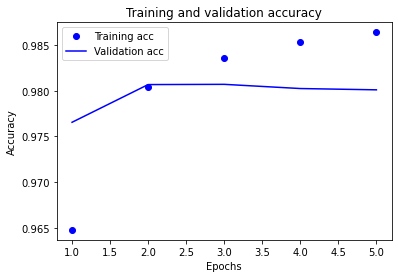

In [73]:
plt.clf()

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### **4.2.4 GRU Model**

In [74]:
GRUmodel = models.Sequential()
GRUmodel.add(Embedding(vocab_size, 128, input_length=max_length))
GRUmodel.add(GRU(64))
GRUmodel.add(Dropout(0.5))
GRUmodel.add(layers.Dense(6, activation='sigmoid'))
GRUmodel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 128)          33608320  
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 33,645,958
Trainable params: 33,645,958
Non-trainable params: 0
_________________________________________________________________


In [75]:
# try using different optimizers and different optimizer configs
GRUmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [76]:
history = GRUmodel.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/10
250/250 [==============================] - 10s 34ms/step - loss: 0.1840 - accuracy: 0.6295 - val_loss: 0.1415 - val_accuracy: 0.9938
Epoch 2/10
250/250 [==============================] - 8s 33ms/step - loss: 0.1448 - accuracy: 0.8738 - val_loss: 0.1380 - val_accuracy: 0.9938
Epoch 3/10
250/250 [==============================] - 8s 33ms/step - loss: 0.0858 - accuracy: 0.9276 - val_loss: 0.0546 - val_accuracy: 0.9941
Epoch 4/10
250/250 [==============================] - 8s 33ms/step - loss: 0.0486 - accuracy: 0.8703 - val_loss: 0.0507 - val_accuracy: 0.9923
Epoch 5/10
250/250 [==============================] - 8s 33ms/step - loss: 0.0406 - accuracy: 0.8015 - val_loss: 0.0531 - val_accuracy: 0.9909
Epoch 6/10
250/250 [==============================] - 8s 33ms/step - loss: 0.0361 - accuracy: 0.7734 - val_loss: 0.0548 - val_accuracy: 0.9858
Epoch 7/10
250/250 [==============================] - 8s 33ms/step - loss: 0.0326 - accuracy: 0.7321 - val_loss: 0.0563 - val_accuracy: 0.988

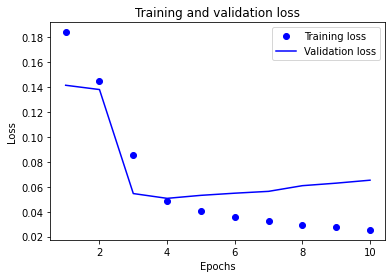

In [77]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

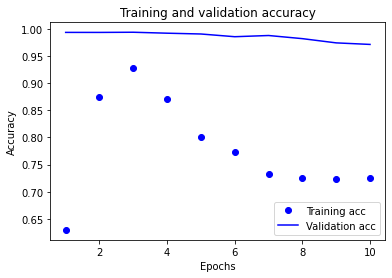

In [78]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [79]:
preds = pd.DataFrame(GRUmodel.predict(x_test), index=test.index, columns=target_cols)

In [80]:
preds.to_csv('GRU_submission.csv')

In [81]:
preds

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.994057,0.259581,0.994157,0.020237,0.933577,0.076717
0000247867823ef7,0.000228,0.000013,0.000014,0.000046,0.000038,0.000030
00013b17ad220c46,0.002875,0.000028,0.000124,0.000051,0.000218,0.000055
00017563c3f7919a,0.000153,0.000013,0.000012,0.000052,0.000031,0.000031
00017695ad8997eb,0.000201,0.000013,0.000013,0.000048,0.000036,0.000031
...,...,...,...,...,...,...
fffcd0960ee309b5,0.481872,0.000165,0.015170,0.000135,0.011013,0.000306
fffd7a9a6eb32c16,0.000271,0.000015,0.000015,0.000055,0.000053,0.000044
fffda9e8d6fafa9e,0.000279,0.000014,0.000017,0.000045,0.000045,0.000031


#### **4.2.5 Bi-GRU Model**

In [82]:
BiGRUmodel = models.Sequential()
BiGRUmodel.add(Embedding(vocab_size, 128, input_length=max_length))
BiGRUmodel.add(Bidirectional(GRU(64)))
BiGRUmodel.add(Dropout(0.5))
BiGRUmodel.add(layers.Dense(6, activation='sigmoid'))
BiGRUmodel.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 128)          33608320  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               74496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 774       
Total params: 33,683,590
Trainable params: 33,683,590
Non-trainable params: 0
_________________________________________________________________


In [83]:
# try using different optimizers and different optimizer configs
BiGRUmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [84]:
history = BiGRUmodel.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/10
250/250 [==============================] - 18s 59ms/step - loss: 0.1214 - accuracy: 0.6715 - val_loss: 0.0544 - val_accuracy: 0.9941
Epoch 2/10
250/250 [==============================] - 14s 57ms/step - loss: 0.0519 - accuracy: 0.8555 - val_loss: 0.0524 - val_accuracy: 0.9934
Epoch 3/10
250/250 [==============================] - 14s 57ms/step - loss: 0.0444 - accuracy: 0.8503 - val_loss: 0.0529 - val_accuracy: 0.9881
Epoch 4/10
250/250 [==============================] - 14s 57ms/step - loss: 0.0393 - accuracy: 0.8092 - val_loss: 0.0537 - val_accuracy: 0.9848
Epoch 5/10
250/250 [==============================] - 14s 57ms/step - loss: 0.0351 - accuracy: 0.7820 - val_loss: 0.0535 - val_accuracy: 0.9818
Epoch 6/10
250/250 [==============================] - 14s 57ms/step - loss: 0.0315 - accuracy: 0.7334 - val_loss: 0.0568 - val_accuracy: 0.9713
Epoch 7/10
250/250 [==============================] - 14s 56ms/step - loss: 0.0285 - accuracy: 0.6609 - val_loss: 0.0592 - val_accuracy:

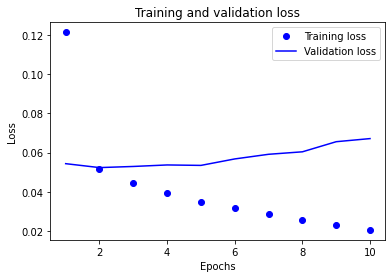

In [85]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

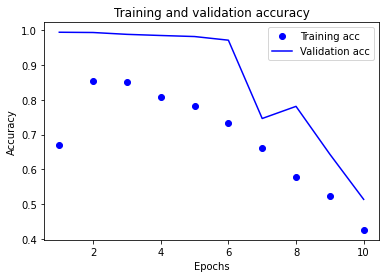

In [86]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()